# Import des librairies

In [35]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

from sklearn import neighbors, svm, model_selection, preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

# Fonctions utiles

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def check_nan(data, title="Carte des NaN"):
    """Affiche une carte des NaN pour un DataFrame ou une seule colonne."""
    
    # Si on reçoit une série, la transformer en DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    plt.figure(figsize=(max(6, data.shape[1] * 0.5), 4))
    sns.heatmap(data.isna(), cbar=False, yticklabels=False, cmap="viridis")
    plt.title(title)
    plt.xlabel("Colonnes")
    plt.show()

# Chargement des données

In [37]:
# Chargement des données silver

df_friches_silver = pd.read_csv("friches_silver.csv", sep=",", low_memory=False, index_col=0)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches_silver.shape[0]} friches chargées — {df_friches_silver.shape[1]} variables")
print("Pas de doublon detectés")

display(df_friches_silver.head(5))

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
2331 friches chargées — 75 variables
Pas de doublon detectés


,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,longitude,latitude,...,site_type_friche_militaire,site_type_friche_portuaire,site_type_mixte,site_actu_annee,site_identif_annee,actualisation_jour,site_actu_mois_sin,site_actu_mois_cos,site_actu_jour_sin,site_actu_jour_cos
17,0,0,2,0,0,0,0,42877,1.337672,43.60932,...,0,0,0,2024,1997,9540,0.866025,5.000000e-01,0.485302,-0.874347
20,0,0,2,0,1,1,0,143,-0.530774,49.29225,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
25,0,1,0,0,0,1,0,28389,-0.546245,49.28301,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
35,0,2,3,0,1,1,0,2619,-0.532152,49.29449,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347
45,0,1,0,0,0,1,0,60709,-0.619462,49.20100,...,0,0,0,2024,2024,0,1.000000,6.123234e-17,0.485302,-0.874347


In [38]:
dict_reconv = {
 "habitat": 0,
 "renaturation": 1,
 "équipement public": 2,
 "mixte": 3,
 "autres activités économiques": 4,
 "aménagement d'espace public": 5,
 "commerce": 6,
 "panneaux photovoltaiques": 7,
 "Energie, hors photovoltaique": 8,
 "bureau": 9,
 "industrie": 10}

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Étape 1 : Séparer X et y
X = df_friches_silver.drop(columns='site_reconv_type')
y = df_friches_silver['site_reconv_type']

# Étape 2 : Fusion/suppression de classes rares
y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]



# Étape 3 : Nettoyage éventuel des colonnes non numériques (au cas où)
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# Étape 5 : Entraînement du modèle Random Forest avec hyperparamètres manuels
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

Accuracy : 0.5613207547169812

Classification Report :
               precision    recall  f1-score   support

           1       0.57      0.29      0.38        14
           2       0.54      0.30      0.39        43
           3       0.52      0.57      0.54        70
           4       0.58      0.80      0.68        66
           6       0.69      0.47      0.56        19

    accuracy                           0.56       212
   macro avg       0.58      0.49      0.51       212
weighted avg       0.56      0.56      0.54       212



Accuracy : 0.5471698113207547

Classification Report :
               precision    recall  f1-score   support

           1       0.40      0.43      0.41        14
           2       0.52      0.37      0.43        43
           3       0.60      0.49      0.54        70
           4       0.60      0.76      0.67        66
           6       0.38      0.53      0.44        19

    accuracy                           0.55       212
   macro avg       0.50      0.51      0.50       212
weighted avg       0.55      0.55      0.54       212



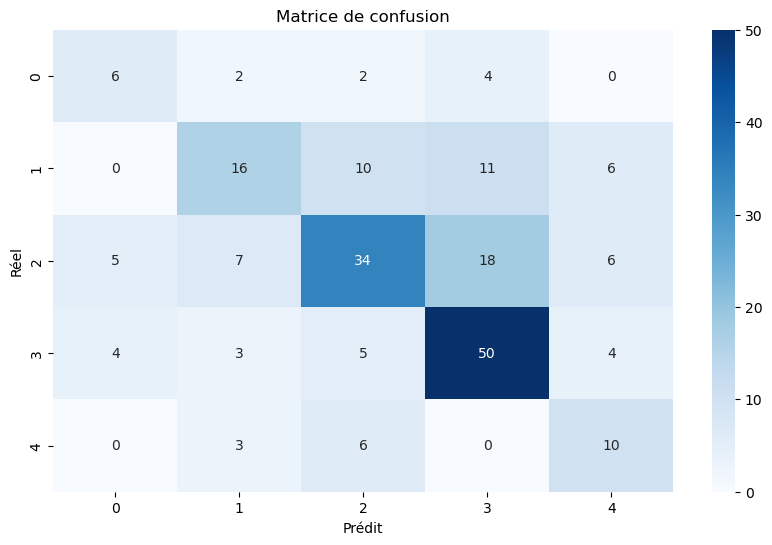

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Chargement du DataFrame propre
# (Assure-toi que df_friches_silver est bien chargé)

# Étape 2 : Nettoyage (suppression des classes trop rares ou douteuses)
y = df_friches_silver['site_reconv_type']
X = df_friches_silver.drop(columns='site_reconv_type')

y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]

# Étape 3 : Nettoyage des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Étape 5 : Modèle avec pondération automatique
clf = RandomForestClassifier(
    n_estimators=400, #besoin de plus estimator ici
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',  # clé ici
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Évaluation
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

# Étape 7 : Visualisation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
from tqdm import tqdm
import numpy as np

# Définir grille
param_grid = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 20, 30]
}

# Création des combinaisons de paramètres
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['min_samples_split'],
    param_grid['max_depth']
))

best_score = -np.inf
best_params = None

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for n_est, min_split, max_d in tqdm(param_combinations, desc="Grid search en cours"):
    clf = RandomForestClassifier(
        n_estimators=n_est,
        min_samples_split=min_split,
        max_depth=max_d,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

    f1_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))

    mean_score = np.mean(f1_scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            'n_estimators': n_est,
            'min_samples_split': min_split,
            'max_depth': max_d
        }

print("\n✅ Meilleurs paramètres trouvés :", best_params)
print("🏆 Score f1_macro moyen :", round(best_score, 4))


Grid search en cours: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


✅ Meilleurs paramètres trouvés : {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 30}
🏆 Score f1_macro moyen : 0.465


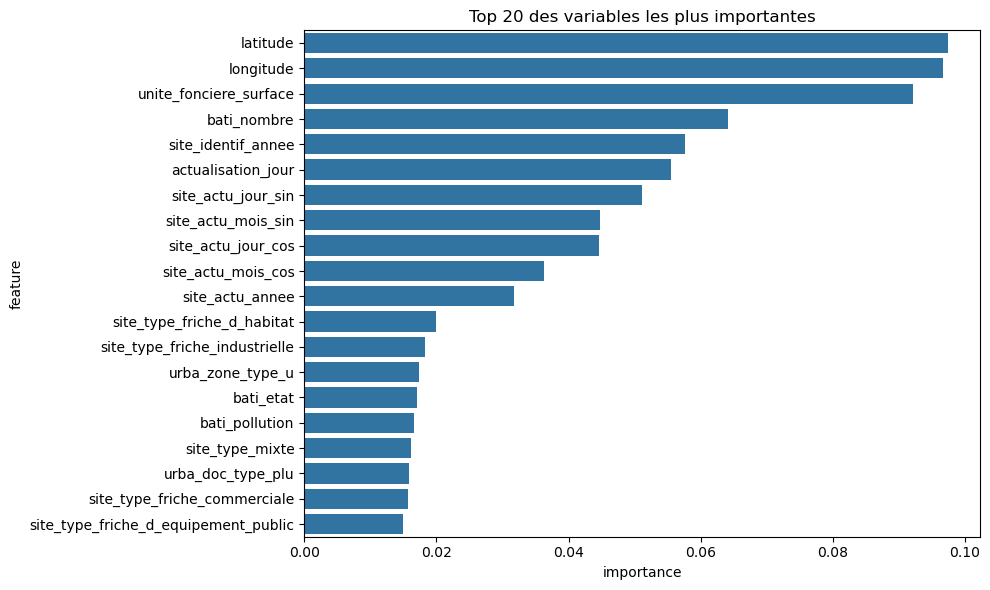

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importance des features
importances = clf.feature_importances_
feature_names = X_train.columns

# Création d’un DataFrame trié
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Affichage graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(20))
plt.title("Top 20 des variables les plus importantes")
plt.tight_layout()
plt.show()


In [68]:
# Extraction des 10 plus importantes (à adapter si tu veux changer de seuil)
top_features = feat_imp_df['feature'].head(10).tolist()

X_reduit = X[top_features]


✅ Accuracy: 0.3584905660377358

📊 Rapport de classification :
              precision    recall  f1-score   support

           1       0.30      0.50      0.38        14
           2       0.23      0.33      0.27        43
           3       0.44      0.23      0.30        70
           4       0.51      0.39      0.44        66
           6       0.32      0.68      0.43        19

    accuracy                           0.36       212
   macro avg       0.36      0.43      0.37       212
weighted avg       0.40      0.36      0.36       212



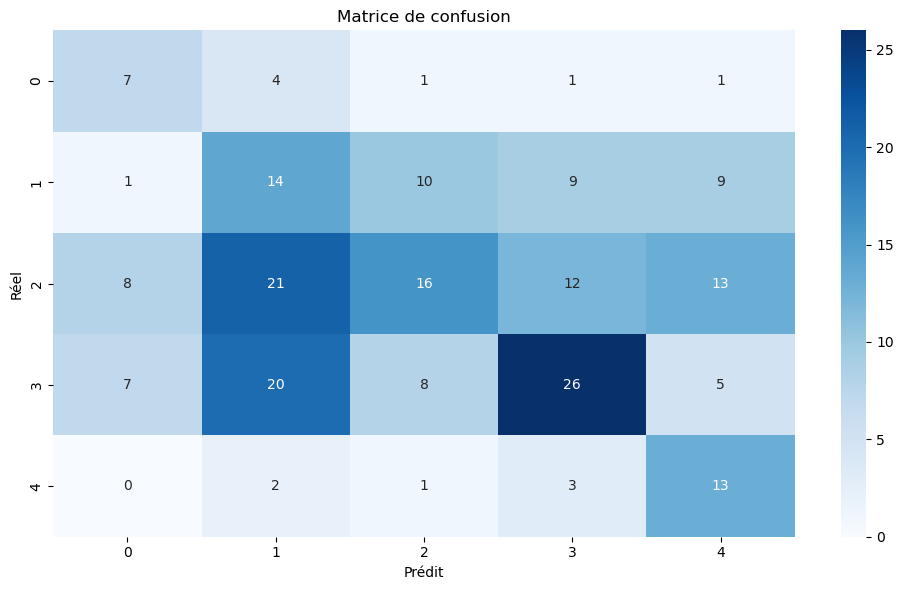

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Étape 1 : Liste des top features d’après importance (visuel fourni)
top_features = [
    'site_securite', 'bati_pollution', 'bati_etat', 'bati_vacance_occupe',
    'bati_vacance_partiellement_occupe', 'bati_vacance_vacant',
    'sol_pollution_existe', 'site_type_friche_industrielle', 'site_type_friche_d_habitat',
    'site_type_mixte', 'urba_zone_type_u', 'urba_doc_type_plui'
]


# Étape 2 : Définition X / y
X = df_friches_silver[top_features].copy()
y = df_friches_silver['site_reconv_type'].copy()

# Étape 3 : Suppression des colonnes non numériques
non_num_cols = X.select_dtypes(include='object').columns
X = X.drop(columns=non_num_cols)

y = y.replace({ 5: -1, 0: -1, 8: -1, 7:-1 , 9:-1, 10: -1}) 
mask = y != -1
X = X[mask]
y = y[mask]

# Étape 4 : Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Étape 5 : Modèle
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=20,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

# Étape 6 : Prédiction et évaluation
y_pred = clf.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

# Étape 7 : Matrice de confusion
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()
